
--- Step 1: Downloading Dataset ---
Dataset Path: /kaggle/input/handwritten-signature-verification

--- Step 3: Parsing & Cleaning Data ---
Scanning 6704 files...
Finished: 6171 valid images found.
Class Balance:
 label
Real      3188
Forged    2983
Name: count, dtype: int64


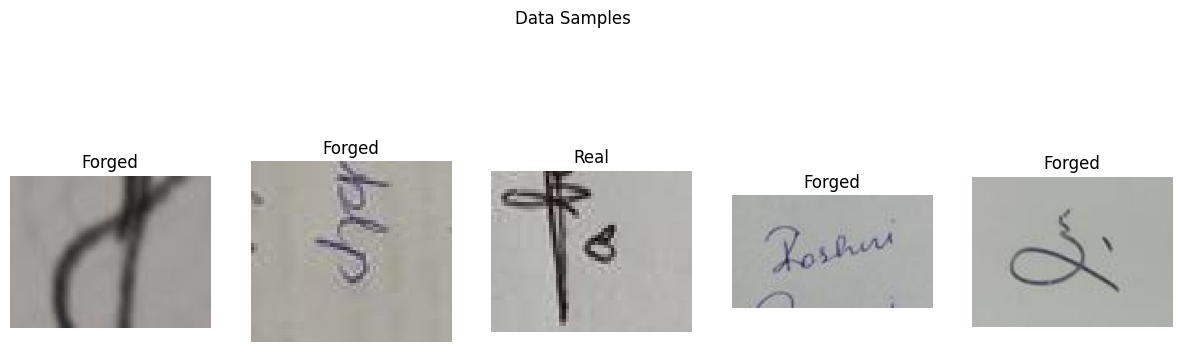

Train: 4319, Val: 926, Test: 926

--- Starting Training ---


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s] 


Epoch 1 | Train Loss: 0.5741 | Val Loss: 0.5074 | Val Acc: 0.7624
Epoch 2 | Train Loss: 0.3703 | Val Loss: 0.4362 | Val Acc: 0.8056
Epoch 3 | Train Loss: 0.2608 | Val Loss: 0.4256 | Val Acc: 0.8067
Epoch 4 | Train Loss: 0.1993 | Val Loss: 0.2713 | Val Acc: 0.8855
Epoch 5 | Train Loss: 0.1454 | Val Loss: 0.2659 | Val Acc: 0.8758
Epoch 6 | Train Loss: 0.1224 | Val Loss: 0.3694 | Val Acc: 0.8639
Epoch 7 | Train Loss: 0.1131 | Val Loss: 0.3843 | Val Acc: 0.8780
Epoch 8 | Train Loss: 0.1036 | Val Loss: 0.3700 | Val Acc: 0.8823
Epoch 9 | Train Loss: 0.1031 | Val Loss: 0.3536 | Val Acc: 0.8812
Epoch 10 | Train Loss: 0.0812 | Val Loss: 0.2992 | Val Acc: 0.8952
Epoch 11 | Train Loss: 0.0489 | Val Loss: 0.3142 | Val Acc: 0.9060
Epoch 12 | Train Loss: 0.0651 | Val Loss: 0.3657 | Val Acc: 0.9039

--- Final Evaluation ---
              precision    recall  f1-score   support

      Forged       0.87      0.89      0.88       447
        Real       0.89      0.88      0.89       479

    accuracy   

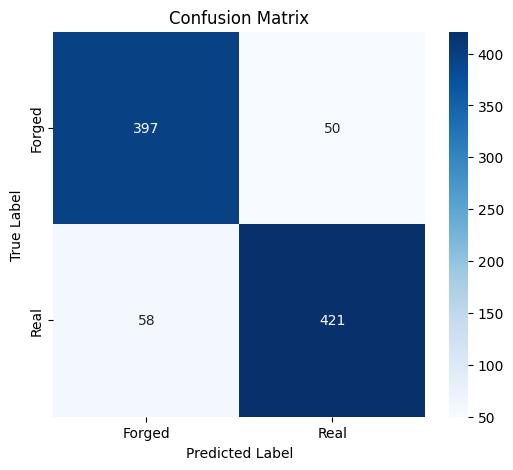

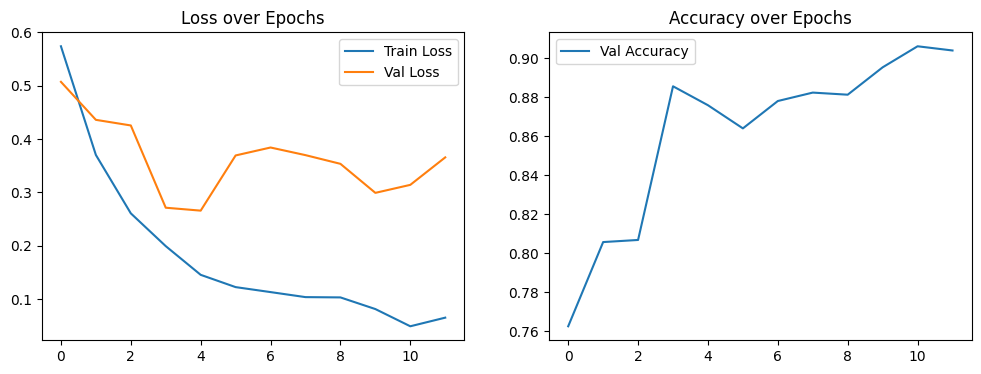

In [1]:
# ==========================================
#  ASSIGNMENT: SIGNATURE VERIFICATION (FINAL V3)
#  Fixed Labeling Logic ("Real" vs "Forged")
# ==========================================

import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn.functional as F
import kagglehub

# 1. SETUP
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

CONFIG = {
    "seed": 42, "batch_size": 32, "lr": 1e-4, "epochs": 12, "img_size": 224,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}
set_seed(CONFIG['seed'])

# 2. DATASET DOWNLOAD
print("\n--- Step 1: Downloading Dataset ---")
path = kagglehub.dataset_download("tienen/handwritten-signature-verification")
print("Dataset Path:", path)

# 3. ROBUST PARSING (Fixed for 'real' folder name)
print("\n--- Step 3: Parsing & Cleaning Data ---")

def parse_dataset(root_path):
    data = []
    all_files = glob.glob(os.path.join(root_path, "**", "*"), recursive=True)
    
    print(f"Scanning {len(all_files)} files...")
    
    valid_count = 0
    
    for img_path in all_files:
        lower_path = img_path.lower()
        
        # 1. Check extension
        if not lower_path.endswith(('.png', '.jpg', '.jpeg')):
            continue
            
        # 2. Assign Label (UPDATED LOGIC HERE)
        if 'genuine' in lower_path or 'real' in lower_path: # <--- ADDED 'real'
            label = 1 # Real/Genuine
        elif 'forg' in lower_path:
            label = 0 # Forged
        else:
            continue 
        
        # 3. Quick Corruption Check
        try:
            # We just check if PIL can identify it, don't fully load to save time
            with Image.open(img_path) as img:
                img.verify() 
            data.append({'path': img_path, 'label': label})
            valid_count += 1
        except:
            continue

    print(f"Finished: {valid_count} valid images found.")
    return pd.DataFrame(data)

df = parse_dataset(path)

# CHECK CLASS BALANCE
print("Class Balance:\n", df['label'].value_counts().rename({0: 'Forged', 1: 'Real'}))

# 4. VISUALIZATION
def visualize_samples(df, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    samples = df.sample(min(num_samples, len(df)))
    
    for i, (_, row) in enumerate(samples.iterrows()):
        try:
            img = Image.open(row['path'])
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"{'Real' if row['label']==1 else 'Forged'}")
            axes[i].axis('off')
        except:
            pass
    plt.suptitle("Data Samples")
    plt.show()

visualize_samples(df)

# 5. SPLIT & TRANSFORMS
# Stratified Split
if len(df['label'].unique()) > 1:
    train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=CONFIG['seed'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=CONFIG['seed'])
else:
    raise ValueError("Still only found 1 class! Please check the folder names in the logs.")

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

train_transforms = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class SignatureDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            image = Image.open(row['path']).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(row['label'], dtype=torch.long)
        except:
            # Return black image if file fails at runtime
            return torch.zeros((3, CONFIG['img_size'], CONFIG['img_size'])), torch.tensor(row['label'], dtype=torch.long)

train_loader = DataLoader(SignatureDataset(train_df, train_transforms), batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(SignatureDataset(val_df, val_transforms), batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(SignatureDataset(test_df, val_transforms), batch_size=CONFIG['batch_size'], shuffle=False)

# 6. MODEL & TRAINING
print("\n--- Starting Training ---")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(CONFIG['device'])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG['lr'])

history = {'loss': [], 'val_loss': [], 'val_acc': []}

for epoch in range(CONFIG['epochs']):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # Validate
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    epoch_loss = running_loss / len(train_loader)
    epoch_val_loss = val_loss / len(val_loader)
    acc = correct / total
    
    history['loss'].append(epoch_loss)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(acc)
    
    print(f"Epoch {epoch+1} | Train Loss: {epoch_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {acc:.4f}")

# 7. EVALUATION
print("\n--- Final Evaluation ---")
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(CONFIG['device']), labels.to(CONFIG['device'])
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)[:, 1] # Prob of 'Real'
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Metrics
print(classification_report(all_labels, all_preds, target_names=['Forged', 'Real']))

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Forged', 'Real'], yticklabels=['Forged', 'Real'])
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()